In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import kagglehub
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
import os
import pickle

In [42]:
# Download dataset
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\steve\.cache\kagglehub\datasets\lakshmi25npathi\imdb-dataset-of-50k-movie-reviews\versions\1


In [ ]:
df = pd.read_csv(path + "/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [44]:
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset shape: (50000, 2)
Columns: ['review', 'sentiment']


In [45]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [46]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [47]:
print("SENTIMENT DISTRIBUTION:")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)
print(f"Dataset balance: {sentiment_counts.min()/sentiment_counts.max():.2f}")

SENTIMENT DISTRIBUTION:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
Dataset balance: 1.00


In [48]:
df['review_length'] = df['review'].str.len()
df['word_count'] = df['review'].str.split().str.len()
print(f"TEXT LENGTH STATISTICS:")
print(f"Character count - Mean: {df['review_length'].mean():.2f}, Std: {df['review_length'].std():.2f}")
print(f"Word count - Mean: {df['word_count'].mean():.2f}, Std: {df['word_count'].std():.2f}")
print(f"Max review length: {df['review_length'].max()} characters")
print(f"Min review length: {df['review_length'].min()} characters")

TEXT LENGTH STATISTICS:
Character count - Mean: 1309.43, Std: 989.73
Word count - Mean: 231.16, Std: 171.34
Max review length: 13704 characters
Min review length: 32 characters


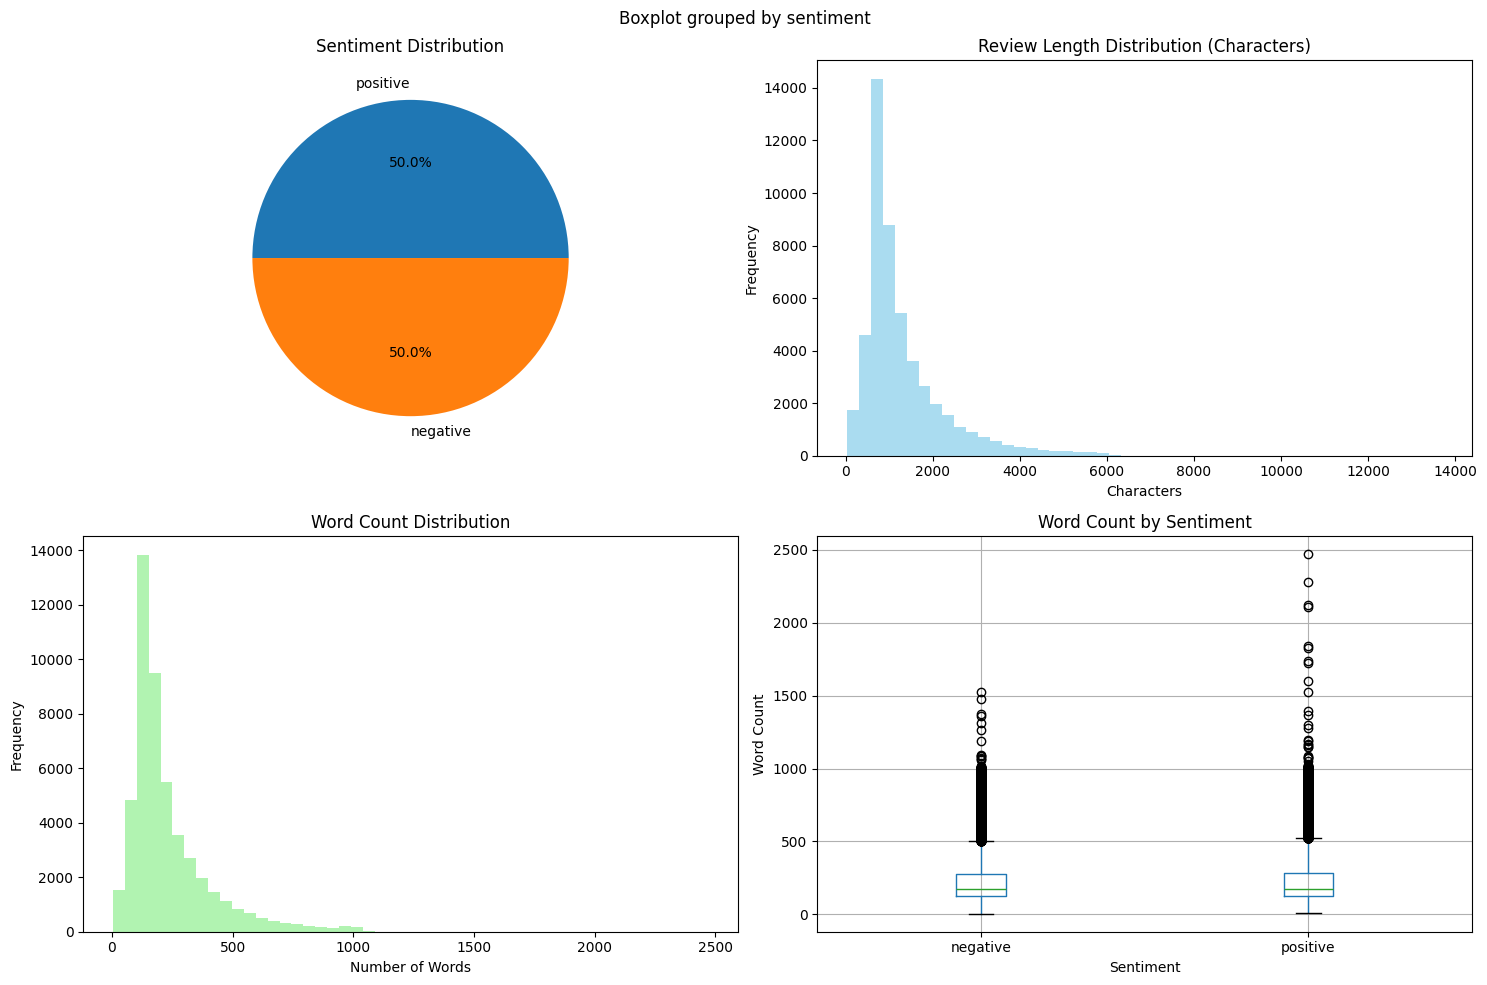

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Sentiment distribution
axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('Sentiment Distribution')

# Review length distribution
axes[0, 1].hist(df['review_length'], bins=50, alpha=0.7, color='skyblue')
axes[0, 1].set_title('Review Length Distribution (Characters)')
axes[0, 1].set_xlabel('Characters')
axes[0, 1].set_ylabel('Frequency')

# Word count distribution
axes[1, 0].hist(df['word_count'], bins=50, alpha=0.7, color='lightgreen')
axes[1, 0].set_title('Word Count Distribution')
axes[1, 0].set_xlabel('Number of Words')
axes[1, 0].set_ylabel('Frequency')

# Box plot for word count by sentiment
df.boxplot(column='word_count', by='sentiment', ax=axes[1, 1])
axes[1, 1].set_title('Word Count by Sentiment')
axes[1, 1].set_xlabel('Sentiment')
axes[1, 1].set_ylabel('Word Count')

plt.tight_layout()
plt.show()

In [50]:
print("SAMPLE POSITIVE REVIEW:")
positive_sample = df[df['sentiment'] == 'positive']['review'].iloc[0]
print(f"Length: {len(positive_sample)} chars, {len(positive_sample.split())} words")
print(f"Text: {positive_sample[:200]}...")

print(f"\nSAMPLE NEGATIVE REVIEW:")
negative_sample = df[df['sentiment'] == 'negative']['review'].iloc[0]
print(f"Length: {len(negative_sample)} chars, {len(negative_sample.split())} words")
print(f"Text: {negative_sample[:200]}...")

SAMPLE POSITIVE REVIEW:
Length: 1761 chars, 307 words
Text: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...

SAMPLE NEGATIVE REVIEW:
Length: 748 chars, 138 words
Text: Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, J...


In [51]:
CONTRACTION_MAP = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot",
    "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
    "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not", "he'd": "he would", "he'll": "he will",
    "he's": "he is", "i'd": "i would", "i'll": "i will", "i'm": "i am",
    "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'll": "it will", "it's": "it is", "let's": "let us",
    "ma'am": "madam", "might've": "might have", "mightn't": "might not",
    "must've": "must have", "mustn't": "must not", "needn't": "need not",
    "oughtn't": "ought not", "shan't": "shall not", "she'd": "she would",
    "she'll": "she will", "she's": "she is", "should've": "should have",
    "shouldn't": "should not", "that'd": "that would", "that's": "that is",
    "there'd": "there would", "there's": "there is", "they'd": "they would",
    "they'll": "they will", "they're": "they are", "they've": "they have",
    "we'd": "we would", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what'll": "what will", "what're": "what are",
    "what's": "what is", "what've": "what have", "where'd": "where did",
    "where's": "where is", "who'll": "who will", "who's": "who is",
    "who've": "who have", "won't": "will not", "wouldn't": "would not",
    "you'd": "you would", "you'll": "you will", "you're": "you are",
    "you've": "you have"
}

In [52]:
df_processed = df.copy()
cleaned_reviews = []

In [53]:
for idx, review in enumerate(df_processed['review']):
  # Konversi menjadi huruf kecil semua
  text = str(review).lower()

  for contraction, expansion in CONTRACTION_MAP.items():
    pattern = r'\b' + re.escape(contraction) + r'\b'
    text = re.sub(pattern, expansion, text)

  #Remove HTML tags
  text = re.sub(r'<[^>]+>', ' ', text)

  #Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)

  #Remove email addresses
  text = re.sub(r'\S+@\S+', ' ', text)

  #Remove punctuation
  text = re.sub(r'[^\w\s]', ' ', text)

  #Remove extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  cleaned_reviews.append(text)

  # Progress indicator
  if (idx + 1) % 5000 == 0:
    print(f"Processed {idx + 1} reviews...")

Processed 5000 reviews...
Processed 10000 reviews...
Processed 15000 reviews...
Processed 20000 reviews...
Processed 25000 reviews...
Processed 30000 reviews...
Processed 35000 reviews...
Processed 40000 reviews...
Processed 45000 reviews...
Processed 50000 reviews...


In [54]:
df_processed['cleaned_review'] = cleaned_reviews
df_processed['label'] = df_processed['sentiment'].map({
    'positive': 1,
    'negative': 0
})

In [55]:
# Menghilangkan review yang mungkin kosong atau kependekan
original_size = len(df_processed)
df_processed = df_processed[df_processed['cleaned_review'].str.len() > 10]
removed_count = original_size - len(df_processed)

In [56]:
# Calculate cleaned text statistics
df_processed['cleaned_length'] = df_processed['cleaned_review'].str.len()
df_processed['cleaned_word_count'] = df_processed['cleaned_review'].str.split().str.len()
print(f"Original size: {original_size}, After cleaning: {len(df_processed)}")
print(f"Removed: {removed_count} empty/short reviews")
print(f"Cleaned text length - Mean: {df_processed['cleaned_length'].mean():.2f}")
print(f"Cleaned word count - Mean: {df_processed['cleaned_word_count'].mean():.2f}")

Original size: 50000, After cleaning: 50000
Removed: 0 empty/short reviews
Cleaned text length - Mean: 1256.62
Cleaned word count - Mean: 235.33


In [57]:
print(f"SAMPLE CLEANED TEXT:")
sample_idx = 0
print(f"Original: {df_processed['review'].iloc[sample_idx][:150]}...")
print(f"Cleaned:  {df_processed['cleaned_review'].iloc[sample_idx][:150]}...")

SAMPLE CLEANED TEXT:
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with...
Cleaned:  one of the other reviewers has mentioned that after watching just 1 oz episode you will be hooked they are right as this is exactly what happened with...


In [58]:
# Show contraction expansion examples found in data
print(f"CONTRACTION EXPANSION EXAMPLES FOUND:")
contraction_examples = []

# Check first 1000 reviews for contractions
for idx in range(min(1000, len(df_processed))):
  original_review = str(df_processed['review'].iloc[idx]).lower()
  for contraction in CONTRACTION_MAP.keys():
    if contraction in original_review:
      example = f"'{contraction}' → '{CONTRACTION_MAP[contraction]}'"
      if example not in contraction_examples:
        contraction_examples.append(example)
        print(f"  Found: {example}")
      if len(contraction_examples) >= 5:  # Show max 5 unique examples
        break
    if len(contraction_examples) >= 5:
      break

if not contraction_examples:
  print("No contractions found in sample data")

CONTRACTION EXPANSION EXAMPLES FOUND:
  Found: 'couldn't' → 'could not'
  Found: 'doesn't' → 'does not'
  Found: 'who'll' → 'who will'
  Found: 'wouldn't' → 'would not'
  Found: 'you'll' → 'you will'
  Found: 'ain't' → 'is not'


In [59]:
X = df_processed['cleaned_review'].values
y = df_processed['label'].values
#10% Data Test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

#10% Data Validation
#10% dari total = 11.1% dari 90%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111, random_state=42, stratify=y_temp
)

total_samples = len(X)
print("OPTIMAL DATA SPLIT SUMMARY:")
print(f"Training set: {len(X_train)} samples ({len(X_train)/total_samples*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/total_samples*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/total_samples*100:.1f}%)")

OPTIMAL DATA SPLIT SUMMARY:
Training set: 40005 samples (80.0%)
Validation set: 4995 samples (10.0%)
Test set: 5000 samples (10.0%)


In [60]:
print("SAMPLE COUNTS (Approximate):")
print(f"Training: {len(X_train):,} samples")
print(f"Validation: {len(X_val):,} samples")
print(f"Test: {len(X_test):,} samples")

SAMPLE COUNTS (Approximate):
Training: 40,005 samples
Validation: 4,995 samples
Test: 5,000 samples


In [61]:
max_features = 15000
max_length = 250

tokenizer = Tokenizer(
    num_words=max_features,
    oov_token='<OOV>',
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)

tokenizer.fit_on_texts(X_train)

In [62]:
import pickle
import os

# Simpan tokenizer dan panjang maksimal
save_path = 'D:\.Portofolio\Coding\Sentiment Analyst C-LSTM'
os.makedirs(save_path, exist_ok=True)

prep_objects = {
    'tokenizer': tokenizer,
    'max_length': max_length
}

with open(os.path.join(save_path, 'preprocessing_objects.pkl'), 'wb') as f:
    pickle.dump(prep_objects, f)

print("Preprocessing objects saved to preprocessing_objects.pkl")

Preprocessing objects saved to preprocessing_objects.pkl


In [63]:
# Vocabulary analysis
vocab_size = len(tokenizer.word_index) + 1
actual_vocab = min(vocab_size, max_features)

print(f"Total vocabulary found: {vocab_size:,}")
print(f"Using top {actual_vocab:,} most frequent words")
print(f"Coverage: {(actual_vocab/vocab_size)*100:.1f}% of unique words")

Total vocabulary found: 92,519
Using top 15,000 most frequent words
Coverage: 16.2% of unique words


In [64]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_seq = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Validation sequences shape: {X_val_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")
print(f"Optimized vocabulary size: {actual_vocab:,}")

Training sequences shape: (40005, 250)
Validation sequences shape: (4995, 250)
Test sequences shape: (5000, 250)
Optimized vocabulary size: 15,000


In [67]:
# --- Best Hyperparameters Found ---
embedding_dim = 256
filters_conv1 = 64
filters_conv2 = 64
kernel_size_conv = 5
pool_size = 3
lstm1_units = 64
lstm2_units = 32
dropout_rate1 = 0.4
dropout_rate2 = 0.3
dropout_rate_final = 0.6
recurrent_dropout_lstm1 = 0.3
recurrent_dropout_lstm2 = 0.2
lstm2_input_dropout = 0.4
dense1_units = 128
learning_rate = 0.0005
optimizer = RMSprop(
    learning_rate=learning_rate,
    rho=0.9,
    momentum=0.0,
    centered=False,
    clipnorm=1.0
)

max_length = 250
vocab_size = actual_vocab

# Model architecture
input_layer = Input(shape=(max_length,), name='input_layer')
embedding = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=max_length,
    mask_zero=True,
    name='embedding_layer'
)(input_layer)

conv1 = Conv1D(
    filters=filters_conv1,
    kernel_size=kernel_size_conv,
    activation='relu',
    padding='same',
    name='conv1d_1'
)(embedding)
conv1_pool = MaxPooling1D(pool_size=pool_size, name='maxpool_1')(conv1)
conv1_dropout = Dropout(dropout_rate1, name='dropout_1')(conv1_pool)

conv2 = Conv1D(
    filters=filters_conv2,
    kernel_size=kernel_size_conv,
    activation='relu',
    padding='same',
    name='conv1d_2'
)(conv1_dropout)
conv2_pool = MaxPooling1D(pool_size=pool_size, name='maxpool_2')(conv2)
conv2_dropout = Dropout(dropout_rate2, name='dropout_2')(conv2_pool)

lstm1 = LSTM(
    lstm1_units,
    return_sequences=True,
    dropout=0.0,
    recurrent_dropout=recurrent_dropout_lstm1,
    name='lstm_1'
)(conv2_dropout)

lstm2 = LSTM(
    lstm2_units,
    dropout=lstm2_input_dropout,
    recurrent_dropout=recurrent_dropout_lstm2,
    name='lstm_2'
)(lstm1)

dense1 = Dense(dense1_units, activation='relu', name='dense_1')(lstm2)
dropout_final = Dropout(dropout_rate_final, name='dropout_final')(dense1)

output = Dense(1, activation='sigmoid', name='output_layer')(dropout_final)

model = Model(inputs=input_layer, outputs=output, name='CLSTM_Sentiment_Classifier')
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

total_params = model.count_params()
print(f"Model size: {total_params:,} parameters")

# Training configuration
batch_size = 64
max_epochs = 15

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True,
    verbose=1,
    mode='min',
    min_delta=0.001
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-7,
    verbose=1,
    mode='min'
)

def scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.1
    return lr

lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Save model
model_save_path = 'D:\.Portofolio\Coding\Sentiment Analyst C-LSTM/best_clstm_model.keras'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model_checkpoint = ModelCheckpoint(
    filepath=model_save_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max'
)

backup_path = 'D:\.Portofolio\Coding\Sentiment Analyst C-LSTM/backup_model.weights.h5'
os.makedirs(os.path.dirname(backup_path), exist_ok=True)

backup_checkpoint = ModelCheckpoint(
    filepath=backup_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
    mode='max'
)

callbacks = [early_stopping, reduce_lr, model_checkpoint, lr_scheduler]

print("TRAINING CONFIGURATION:")
print(f"- Training samples: {len(X_train_seq)}")
print(f"- Validation samples: {len(X_val_seq)}")
print(f"- Batch size: {batch_size}")
print(f"- Max epochs: {max_epochs}")
print(f"- Early stopping patience: 1")
print(f"- Learning rate reduction patience: 1")

print("\nStarting C-LSTM training...")
history = model.fit(
    X_train_seq, y_train,
    batch_size=batch_size,
    epochs=max_epochs,
    validation_data=(X_val_seq, y_val),
    callbacks=callbacks,
    verbose=1
)

Model size: 3,992,321 parameters
TRAINING CONFIGURATION:
- Training samples: 40005
- Validation samples: 4995
- Batch size: 64
- Max epochs: 15
- Early stopping patience: 1
- Learning rate reduction patience: 1

Starting C-LSTM training...

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/15
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5103 - loss: 0.6885 - precision: 0.5107 - recall: 0.5325
Epoch 1: val_accuracy improved from -inf to 0.75295, saving model to D:\.Portofolio\Coding\Sentiment Analyst C-LSTM/best_clstm_model.keras
626/626 ━━━━━━━━━━━━━━━━━━━━ 62s 91ms/step - accuracy: 0.5105 - loss: 0.6884 - precision: 0.5109 - recall: 0.5326 - val_accuracy: 0.7530 - val_loss: 0.5133 - val_precision: 0.9281 - val_recall: 0.5483 - learning_rate: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 2/15
625/626 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.8388 - loss: 0.3855 - precision: 0.8376 -

In [68]:
# Display training summary
epochs_completed = len(history.history['accuracy'])
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])

final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

final_precision = history.history['precision'][-1]
final_recall = history.history['recall'][-1]

print("TRAINING SUMMARY:")
print(f"Epochs completed         : {epochs_completed}")
print(f"Final training accuracy  : {final_train_acc:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")
print(f"Best validation accuracy : {best_val_acc:.4f}")
print(f"Final training loss      : {final_train_loss:.4f}")
print(f"Final validation loss    : {final_val_loss:.4f}")
print(f"Final precision          : {final_precision:.4f}")
print(f"Final recall             : {final_recall:.4f}")

TRAINING SUMMARY:
Epochs completed         : 4
Final training accuracy  : 0.9229
Final validation accuracy: 0.8923
Best validation accuracy : 0.8923
Final training loss      : 0.2113
Final validation loss    : 0.3106
Final precision          : 0.9207
Final recall             : 0.9255


In [69]:
overfitting_gap = final_train_acc - final_val_acc
if overfitting_gap > 0.05:
  print(f"Potential overfitting detected (gap: {overfitting_gap:.3f})")
else:
  print(f"Good generalization (gap: {overfitting_gap:.3f})")

Good generalization (gap: 0.031)



Evaluating model on test set...
Generating predictions...
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
Computing evaluation metrics...
TEST SET PERFORMANCE RESULTS
Test Loss      : 0.2686
Test Accuracy  : 0.8858 (88.58%)
Test Precision : 0.8778
Test Recall    : 0.8964
Test F1-Score  : 0.8870

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.88      2500
    Positive       0.88      0.90      0.89      2500

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000


CONFUSION MATRIX:
[[2188  312]
 [ 259 2241]]

CONFUSION MATRIX BREAKDOWN:
True Negatives (TN):  2188
False Positives (FP): 312
False Negatives (FN): 259
True Positives (TP):  2241

PER-CLASS PERFORMANCE:
Negative class accuracy: 0.8752
Positive class accuracy: 0.8964


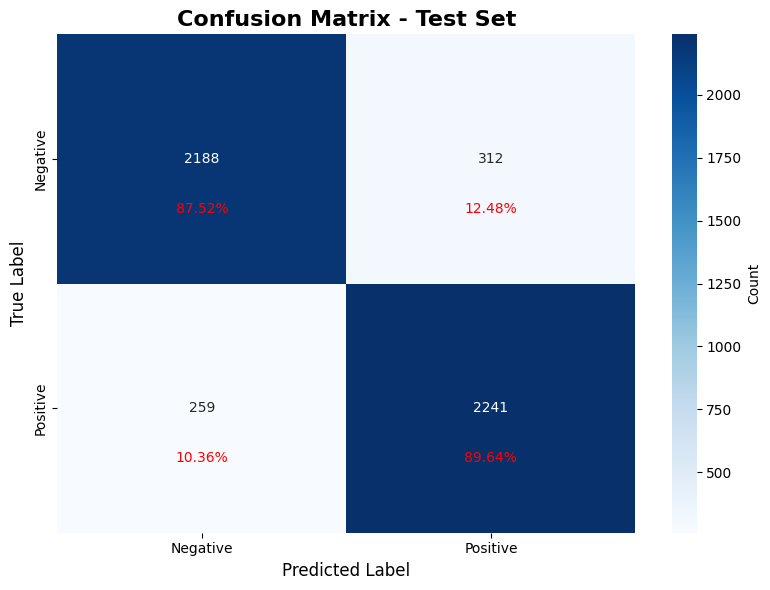

In [70]:
print("\nEvaluating model on test set...")

# Generate predictions on test set
print("Generating predictions...")
y_pred_prob = model.predict(X_test_seq, batch_size=128, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Evaluate model using Keras evaluate function
print("Computing evaluation metrics...")
test_results = model.evaluate(X_test_seq, y_test, verbose=0, batch_size=128)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]

# Calculate F1-score manually
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-8)

# Display comprehensive results
print("=" * 60)
print("TEST SET PERFORMANCE RESULTS")
print("=" * 60)
print(f"Test Loss      : {test_loss:.4f}")
print(f"Test Accuracy  : {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")
print(f"Test Precision : {test_precision:.4f}")
print(f"Test Recall    : {test_recall:.4f}")
print(f"Test F1-Score  : {test_f1:.4f}")

# Detailed classification report
print("\nDETAILED CLASSIFICATION REPORT:")
class_names = ['Negative', 'Positive']
classification_rep = classification_report(y_test, y_pred, target_names=class_names)
print(classification_rep)

# Generate and display confusion matrix
print("\nCONFUSION MATRIX:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Confusion matrix breakdown
tn, fp, fn, tp = cm.ravel()
print("\nCONFUSION MATRIX BREAKDOWN:")
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")

# Per-class accuracy
negative_accuracy = tn / (tn + fp) if (tn + fp) > 0 else 0
positive_accuracy = tp / (tp + fn) if (tp + fn) > 0 else 0
print("\nPER-CLASS PERFORMANCE:")
print(f"Negative class accuracy: {negative_accuracy:.4f}")
print(f"Positive class accuracy: {positive_accuracy:.4f}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add percentage annotations
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j + 0.5, i + 0.7, f'{cm_percent[i, j]:.2%}',
                 ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

In [71]:
# Pastikan semua array memiliki panjang yang sama
# Use X_test instead of X_test_raw
max_len = min(len(y_test), len(y_pred), len(y_pred_prob), len(X_test))

# Potong semuanya ke panjang minimum
y_test = y_test[:max_len]
y_pred = y_pred[:max_len]
y_pred_prob = y_pred_prob[:max_len]
# Use X_test instead of X_test_raw
X_test = X_test[:max_len]

# Hitung confidence score langsung dari probabilitas
confidence_scores = y_pred_prob.flatten()

# Buat mask untuk benar/salah prediksi
correct_mask = (y_pred == y_test)
incorrect_mask = ~correct_mask

correct_indices = np.where(correct_mask)[0]
incorrect_indices = np.where(incorrect_mask)[0]

print(f"\nPREDICTION SAMPLES:")
print(f"Correct predictions  : {np.sum(correct_mask)} ({np.sum(correct_mask) / len(y_test) * 100:.1f}%)")
print(f"Incorrect predictions: {np.sum(incorrect_mask)} ({np.sum(incorrect_mask) / len(y_test) * 100:.1f}%)")
print()
print("-"*50)
# Tampilkan contoh prediksi benar
print(f"\nCORRECT PREDICTION EXAMPLES:")

for i, idx in enumerate(correct_indices[:3]):
    prob = y_pred_prob[idx][0] if y_pred_prob.ndim > 1 else y_pred_prob[idx]
    confidence = confidence_scores[idx]
    pred_label = "Positive" if y_pred[idx] == 1 else "Negative"
    true_label = "Positive" if y_test[idx] == 1 else "Negative"

    print(f"\nExample {i+1}:")
    print(f"True: {true_label}, Predicted: {pred_label}")
    print(f"Probability: {prob:.3f}, Confidence: {confidence:.3f}")
    # Use X_test instead of X_test_raw
    print(f"Text: {X_test[idx][:150]}...")

print()
# Tampilkan contoh prediksi salah
print("-"*50)
print(f"\nINCORRECT PREDICTION EXAMPLES:")

for i, idx in enumerate(incorrect_indices[:3]):
    prob = y_pred_prob[idx][0] if y_pred_prob.ndim > 1 else y_pred_prob[idx]
    confidence = confidence_scores[idx]
    pred_label = "Positive" if y_pred[idx] == 1 else "Negative"
    true_label = "Positive" if y_test[idx] == 1 else "Negative"

    print(f"\nExample {i+1}:")
    print(f"True: {true_label}, Predicted: {pred_label}")
    print(f"Probability: {prob:.3f}, Confidence: {confidence:.3f}")
    # Use X_test instead of X_test_raw
    print(f"Text: {X_test[idx][:150]}...")


PREDICTION SAMPLES:
Correct predictions  : 4429 (88.6%)
Incorrect predictions: 571 (11.4%)

--------------------------------------------------

CORRECT PREDICTION EXAMPLES:

Example 1:
True: Positive, Predicted: Positive
Probability: 0.526, Confidence: 0.526
Text: i am not kidding about that summary and vote the video distributors have packaged this as just another typical 80s werewolf movie but it is in fact th...

Example 2:
True: Negative, Predicted: Negative
Probability: 0.262, Confidence: 0.262
Text: i kept waiting for the film to move me inspire me shock me sadden me in some way but it stirred none of my emotions it just meandered along to the end...

Example 3:
True: Negative, Predicted: Negative
Probability: 0.023, Confidence: 0.023
Text: this movie is a 90 minute ramones concert with brief periods of stupidity and absolute boredom what kind of high school is this anyway unless you are ...

--------------------------------------------------

INCORRECT PREDICTION EXAMPLES:

Exa

# Test Prediction

In [75]:
CONTRACTION_MAP = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot",
    "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
    "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not", "he'd": "he would", "he'll": "he will",
    "he's": "he is", "i'd": "i would", "i'll": "i will", "i'm": "i am",
    "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'll": "it will", "it's": "it is", "let's": "let us",
    "ma'am": "madam", "might've": "might have", "mightn't": "might not",
    "must've": "must have", "mustn't": "must not", "needn't": "need not",
    "oughtn't": "ought not", "shan't": "shall not", "she'd": "she would",
    "she'll": "she will", "she's": "she is", "should've": "should have",
    "shouldn't": "should not", "that'd": "that would", "that's": "that is",
    "there'd": "there would", "there's": "there is", "they'd": "they would",
    "they'll": "they will", "they're": "they are", "they've": "they have",
    "we'd": "we would", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what'll": "what will", "what're": "what are",
    "what's": "what is", "what've": "what have", "where'd": "where did",
    "where's": "where is", "who'll": "who will", "who's": "who is",
    "who've": "who have", "won't": "will not", "wouldn't": "would not",
    "you'd": "you would", "you'll": "you will", "you're": "you are",
    "you've": "you have"
}

# Load Preprocessing Objects
with open('D:\.Portofolio\Coding\Sentiment Analyst C-LSTM\preprocessing_objects.pkl', 'rb') as f:
  prep_objects = pickle.load(f)
  saved_tokenizer = prep_objects['tokenizer']

# Load the Trained Model
model_path = 'D:\.Portofolio\Coding\Sentiment Analyst C-LSTM/best_clstm_model.keras'
model = load_model(model_path)

max_len_padding = 250


def predict_sentiment_direct(text_input, model, tokenizer, max_len_padding):
    text = str(text_input).lower()

    # Expand contractions (pastikan regex menggunakan r'\b')
    for contraction, expansion in CONTRACTION_MAP.items():
        pattern = r'\b' + re.escape(contraction) + r'\b'
        text = re.sub(pattern, expansion, text)

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', ' ', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Handle empty or very short text after cleaning
    if len(text.strip()) < 2:
        return {
            'original_text': text_input[:100] + "..." if len(text_input) > 100 else text_input,
            'cleaned_text': text[:100] + "..." if len(text) > 100 else text,
            'prediction': 'neutral',
            'probability': 0.5,
            'confidence': 0.5,
            'status': 'warning',
            'message': 'Text too short or empty after cleaning'
        }


    sequence = tokenizer.texts_to_sequences([text])
    # Pastikan maxlen di pad_sequences menggunakan max_len_padding (250)
    padded = pad_sequences(sequence, maxlen=max_len_padding, padding='post', truncating='post')
    probability = model.predict(padded, batch_size=1, verbose=0)[0][0]


    prediction = "positive" if probability > 0.5 else "negative"
    confidence = probability if probability > 0.5 else 1 - probability

    if confidence > 0.9: conf_level = "very_high"
    elif confidence > 0.8: conf_level = "high"
    elif confidence > 0.7: conf_level = "medium"
    else: conf_level = "low"

    return {
        'original_text': text_input[:100] + "..." if len(text_input) > 100 else text_input,
        'cleaned_text': text[:100] + "..." if len(text) > 100 else text,
        'prediction': prediction,
        'probability': float(probability), # Ensure it's a standard float
        'confidence': float(confidence), # Ensure it's a standard float
        'confidence_level': conf_level,
        'status': 'success'
    }

def predict_single_sentence(text_input):
    global model, saved_tokenizer, max_len_padding, CONTRACTION_MAP
    cleaned_text = str(text_input).lower()

    for contraction, expansion in CONTRACTION_MAP.items():
        pattern = r'\b' + re.escape(contraction) + r'\b'
        cleaned_text = re.sub(pattern, expansion, cleaned_text)

    cleaned_text = re.sub(r'<[^>]+>', ' ', cleaned_text)
    cleaned_text = re.sub(r'http\S+|www\S+|https\S+', ' ', cleaned_text, flags=re.MULTILINE)
    cleaned_text = re.sub(r'\S+@\S+', ' ', cleaned_text)
    cleaned_text = re.sub(r'[^\w\s]', ' ', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    # Handle empty or very short text after cleaning
    if len(cleaned_text.strip()) < 2:
        return {
            'Text': text_input,
            'Prediction': 'Cannot Predict',
            'Confidence': 0.0,
            'Probability': 0.5,
            'Message': 'Text too short or empty after cleaning'
        }

    # Tokenize and pad the sequence
    sequence = saved_tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len_padding, padding='post', truncating='post')

    # Get probability prediction from the model
    probability = model.predict(padded_sequence, verbose=0)[0][0]

    # Determine prediction label and confidence
    prediction_label = "Positive" if probability > 0.5 else "Negative"
    confidence = probability if probability > 0.5 else 1 - probability

    return {
        'Text': text_input,
        'Prediction': prediction_label,
        'Confidence': float(confidence),
        'Probability': float(probability)
    }

# --- Example Usage ---
print("\n--- TESTING SINGLE SENTENCE PREDICTION ---")
while True:
  num_sentences = int(input("Masukkan jumlah kalimat yang ingin Anda prediksi: "))
  if num_sentences > 0:
    break
  else:
    print("Jumlah harus lebih besar dari nol.")

print("-" * 30)

for i in range(num_sentences):
    input_sentence = input(f"Masukkan kalimat ke-{i+1} untuk prediksi sentimen: ")
    result = predict_single_sentence(input_sentence)

    print(f"\nHasil Prediksi Kalimat ke-{i+1}:")
    print(f"  Teks Asli: {result['Text']}")
    print(f"  Prediksi: {result['Prediction']}")
    print(f"  Keyakinan (Confidence): {result['Confidence']:.4f}")
    print(f"  Probabilitas Positif: {result['Probability']:.4f}")

    if 'Message' in result:
        print(f"  Pesan: {result['Message']}")
    print("-" * 30)


--- TESTING SINGLE SENTENCE PREDICTION ---
------------------------------

Hasil Prediksi Kalimat ke-1:
  Teks Asli: Terrible movie. Poor acting, boring plot, complete waste of time. I want my money back.
  Prediksi: Negative
  Keyakinan (Confidence): 0.9941
  Probabilitas Positif: 0.0059
------------------------------
